# Analysis of compression experiments

In [1]:
import torch
from torch import nn
import torch.nn.functional as F
from dataclasses import dataclass
from einops import einsum
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display
import pickle

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device:', device)

# Bilinear layer similar to the other notebook (left/right via chunk)
class Bilinear(nn.Linear):
    def __init__(self, d_in: int, d_out: int, bias=False) -> None:
        super().__init__(d_in, 2 * d_out, bias=bias)
    def forward(self, x):
        left, right = super().forward(x).chunk(2, dim=-1)
        return left * right
    @property
    def w_l(self):
        return self.weight.chunk(2, dim=0)[0]
    @property
    def w_r(self):
        return self.weight.chunk(2, dim=0)[1]

@dataclass
class ModelConfig:
    p: int = 64
    d_hidden: int | None = None
    bias: bool = False

class Model(nn.Module):
    def __init__(self, cfg: ModelConfig):
        super().__init__()
        self.bi_linear = Bilinear(d_in=2*cfg.p, d_out=cfg.d_hidden, bias=cfg.bias)
        self.projection = nn.Linear(cfg.d_hidden, cfg.p, bias=cfg.bias)
    def forward(self, x):
        return self.projection(self.bi_linear(x))
    @property
    def w_l(self):
        return self.bi_linear.w_l
    @property
    def w_r(self):
        return self.bi_linear.w_r
    @property
    def w_p(self):
        return self.projection.weight

def init_model(p, d_hidden):
    cfg = ModelConfig(p=p, d_hidden=d_hidden, bias=False)
    return Model(cfg)


Device: cuda


## Loading trained models and final validation accuracies

In [2]:
import time
import pickle
import torch
import matplotlib.pyplot as plt
import numpy as np

with open('sweep_results_0401.pkl', 'rb') as f:
    data = pickle.load(f)
models_state = data.get('models', data.get('models_state', {}))
remainders = data.get('remainders', None)
int_mats = data.get("int_mats", {})
val_acc = data.get("val_accs", {})
dims = sorted(list(models_state.keys()), reverse=True)
print(f'Found saved models for dims: {dims}')

Found saved models for dims: [64, 63, 62, 61, 60, 59, 58, 57, 56, 55, 54, 53, 52, 51, 50, 49, 48, 47, 46, 45, 44, 43, 42, 41, 40, 39, 38, 37, 36, 35, 34, 33, 32, 31, 30, 29, 28, 27, 26, 25, 24, 23, 22, 21, 20, 19, 18, 17, 16, 15, 14, 13, 12, 11, 10, 9, 8, 7, 6, 5, 4, 3, 2, 1]


## Validation curve

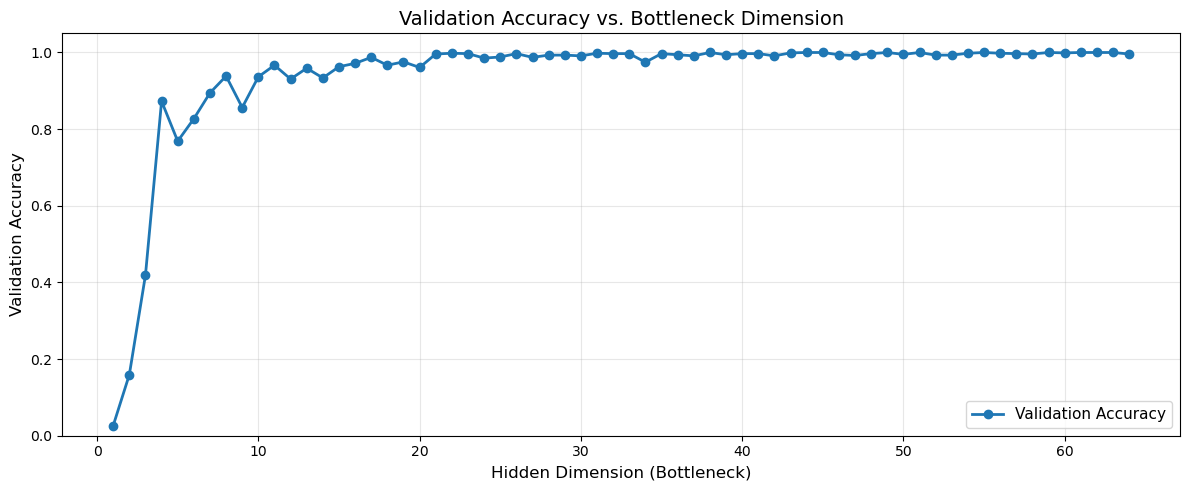

IntSlider(value=0, description='Dim Index', max=63, step=-1)

Output()

In [3]:
# Visualize validation accuracies across bottleneck dimensions
if len(val_acc) == 0:
    print('No validation accuracies available. Run the sweep cell first.')
else:
    dims_sorted = sorted(list(val_acc.keys()), reverse=True)  # P down to 1
    accs_sorted = [val_acc[d] for d in dims_sorted]
    
    # Plot all accuracies
    fig, ax = plt.subplots(figsize=(12, 5))
    ax.plot(dims_sorted, accs_sorted, 'o-', linewidth=2, markersize=6, label='Validation Accuracy')
    ax.set_xlabel('Hidden Dimension (Bottleneck)', fontsize=12)
    ax.set_ylabel('Validation Accuracy', fontsize=12)
    ax.set_title('Validation Accuracy vs. Bottleneck Dimension', fontsize=14)
    ax.grid(True, alpha=0.3)
    ax.legend(fontsize=11)
    ax.set_ylim([0, 1.05])
    plt.tight_layout()
    plt.show()
    
    # Interactive slider to inspect individual dim
    def show_acc(dim_idx=0):
        d = dims_sorted[dim_idx]
        acc = val_acc[d]
        print(f'd_hidden = {d:2d}  →  Validation Accuracy = {acc:.4f}')
    
    dim_slider = widgets.IntSlider(min=0, max=len(dims_sorted)-1, step=-1, description='Dim Index')
    out = widgets.interactive_output(show_acc, {'dim_idx': dim_slider})
    display(dim_slider, out)

Looking at the validation accuracy curve, it is clear that a lot of compression is possible. The smallest bottleneck dimension with perfect generalisation `val_acc = 1.0` was 38. Looking the curve, it is clear however, that the model performs well at least down to bottleneck dim 20. There is a steep decline in performance starting around bottleneck dimension 10.    

## Interaction matrices

In [4]:

# Interactive exploration of computed interaction matrices
if len(int_mats) == 0:
    print('No interaction matrices available. Run the sweep cell first.')
else:
    dims_avail = sorted(list(int_mats.keys()))
    def show_mat(dim_idx=0, rem_idx=0, clim=0.0):
        d = dims_avail[dim_idx]
        mat = int_mats[d][rem_idx].numpy()
        plt.figure(figsize=(6,5))
        if clim and clim>0:
            vmax = np.abs(mat).max() * clim
            vmin = -vmax
            im = plt.imshow(mat, cmap='RdBu', vmin=vmin, vmax=vmax, aspect='auto', origin="lower")
        else:
            im = plt.imshow(mat, cmap='RdBu', aspect='auto', origin="lower")
        plt.colorbar(im, fraction=0.046, pad=0.04)
        plt.title(f'd_hidden={d}, remainder={remainders[rem_idx]}')
        plt.show()
    dim_slider = widgets.IntSlider(min=0, max=len(dims_avail)-1, step=1, description='dim idx')
    rem_slider = widgets.IntSlider(min=0, max=len(remainders)-1, step=1, description='rem idx')
    clim_slider = widgets.FloatSlider(value=0.0, min=0.0, max=1.0, step=0.05, description='clim')
    out = widgets.interactive_output(show_mat, {'dim_idx': dim_slider, 'rem_idx': rem_slider, 'clim': clim_slider})
    display(widgets.HBox([dim_slider, rem_slider, clim_slider]), out)

Output()

## Cosine similarity

In [ ]:
def inner_product(model1: Model, model2: Model) -> torch.FloatTensor:
    l_12 = einsum(model1.w_l, model2.w_l, "hid1 i, hid2 i -> hid1 hid2")
    r_12 = einsum(model1.w_r, model2.w_r, "hid1 i, hid2 i -> hid1 hid2")
    lr = l_12 * r_12
    dd = einsum(model1.w_p, model2.w_p, "o hid1, o hid2 -> hid1 hid2")
    hid = einsum(lr, dd, "hid1 hid2, hid1 hid3 -> hid2 hid3")
    return torch.trace(hid)

def symmetric_inner(model1: Model, model2: Model) -> torch.FloatTensor:
    ll = einsum(model1.w_l, model2.w_l, "hid1 i, hid2 i -> hid1 hid2")
    rr = einsum(model1.w_r, model2.w_r, "hid1 i, hid2 i -> hid1 hid2")

    lr = einsum(model1.w_l, model2.w_r, "hid1 i, hid2 i -> hid1 hid2")
    rl = einsum(model1.w_r, model2.w_l, "hid1 i, hid2 i -> hid1 hid2")

    core = 1/2 * ((ll*rr) + (lr+rl))
    
    dd = einsum(model1.w_p, model2.w_p, "o hid1, o hid2 -> hid1 hid2")
    hid = einsum(core, dd, "hid1 hid2, hid1 hid3 -> hid2 hid3")
    return torch.trace(hid)

def tn_similarity(model1: Model, model2: Model) -> torch.FloatTensor:
    if model1 == model2:
        return torch.tensor(1.0)
    inner = inner_product(model1, model2)
    norm1 = torch.sqrt(inner_product(model1, model1))
    norm2 = torch.sqrt(inner_product(model2, model2))
    return inner / (norm1 * norm2)

def symmetric_similarity(model1: Model, model2: Model) -> torch.FloatTensor:
    if model1 == model2:
        return torch.tensor(1.0)
    inner = symmetric_inner(model1, model2)
    norm1 = torch.sqrt(symmetric_inner(model1, model1))
    norm2 = torch.sqrt(symmetric_inner(model2, model2))
    return inner / (norm1 * norm2)

TN similarity d=64 vs d=63: 0.103855 (computed in 1.234s)
Computing full pairwise TN similarity matrix...


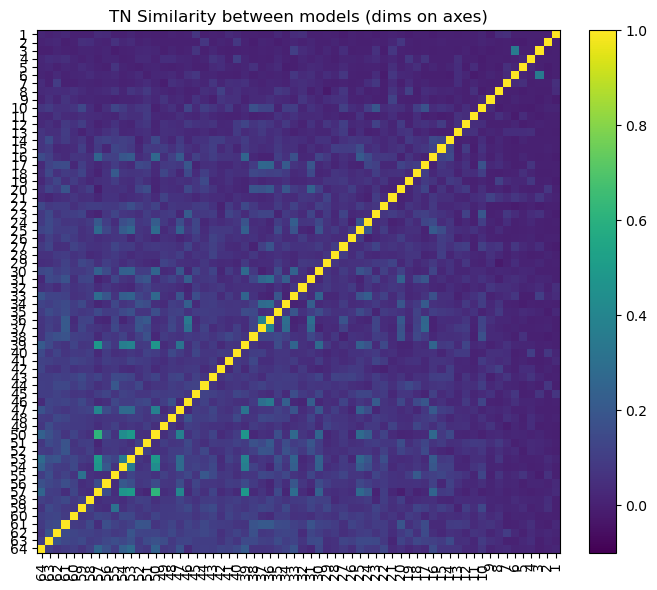

In [6]:

# helper: instantiate and load model for a given dim
def load_model_for_dim(d):
    m = init_model(64, d)
    state = models_state[d]
    m.load_state_dict(state)
    return m

# Time similarity computation for d=64 vs d=63 if available
if 64 in models_state and 63 in models_state:
    m64 = load_model_for_dim(64)
    m63 = load_model_for_dim(63)
    torch.set_grad_enabled(False)
    t0 = time.perf_counter()
    sim_64_63 = tn_similarity(m64, m63)
    t1 = time.perf_counter()
    dt = t1 - t0
    print(f'TN similarity d=64 vs d=63: {sim_64_63:.6f} (computed in {dt:.3f}s)')
else:
    print('Models for d=64 or d=63 not found in saved states; skipping timing check')

# If timing is reasonable, compute full pairwise similarity matrix and plot heatmap
time_threshold = 10.0  # seconds; adjust as needed
if 'dt' in locals() and dt < time_threshold:
    print('Computing full pairwise TN similarity matrix...')
    n = len(dims)
    sim_mat = np.zeros((n, n), dtype=float)
    models_cache = {}
    for i, di in enumerate(dims):
        models_cache[di] = load_model_for_dim(di)
    for i, di in enumerate(dims):
        for j, dj in enumerate(dims):
            if j < i:
                sim_mat[i, j] = sim_mat[j, i] # no need to repeat computations. similarity matrix is symmetric
            else:
                s = float(tn_similarity(models_cache[di], models_cache[dj]))
                sim_mat[i, j] = s
    # Plot heatmap
    fig, ax = plt.subplots(figsize=(8, 6))
    im = ax.imshow(sim_mat, cmap='viridis', vmin=-0.1, vmax=1, origin="lower")
    ax.set_xticks(np.arange(n))
    ax.set_yticks(np.arange(n))
    ax.set_xticklabels(dims, rotation=90)
    ax.set_yticklabels(dims)
    ax.set_title('TN Similarity between models (dims on axes)')
    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    plt.tight_layout()
    plt.show()
else:
    print(f'Skipping full matrix: dt={locals().get(dt, None)} not < {time_threshold}s')